<a href="https://colab.research.google.com/github/skywalker0803r/mxnet_course/blob/master/mxnet_ppo_lunarlander-v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
#!pip install mxnet
import numpy as np 
import mxnet as mx 
from mxnet import gluon, autograd, nd
import mxnet.ndarray as F
from mxnet.gluon import nn
from mxnet.gluon.loss import L2Loss
import gym
from mxnet import init
import matplotlib.pyplot as plt

# some function

In [0]:
def nd_entropy(probs):
  return -nd.sum(probs*nd.log(probs+1e-8),axis=1)

# memory

In [0]:
class Memory:
  def __init__(self):
    self.actions = []
    self.states = []
    self.logprobs = []
    self.rewards = []
    self.is_terminals = []
  def clear_memory(self):
    del self.actions[:]
    del self.states[:]
    del self.logprobs[:]
    del self.rewards[:]
    del self.is_terminals[:]

# model

In [0]:
class ActorCritic_Discrete(gluon.Block):
  def __init__(self,action_dim):
    super(ActorCritic_Discrete, self).__init__()
    self.action_dim = action_dim
    with self.name_scope():
      self.probs = nn.Sequential()
      self.probs.add(nn.Dense(64,activation='relu'))
      self.probs.add(nn.Dense(64,activation='relu'))
      self.probs.add(nn.Dense(64,activation='relu'))
      self.probs.add(nn.Dense(action_dim))
      
      self.value = nn.Sequential()
      self.value.add(nn.Dense(64,activation='relu'))
      self.value.add(nn.Dense(64,activation='relu'))
      self.value.add(nn.Dense(64,activation='relu'))
      self.value.add(nn.Dense(1))       
  
  def choose_action(self, state, memory):
    state = nd.array(state)
    probs = nd.softmax(self.probs(state))
    action, log_prob = nd.sample_multinomial(probs, get_prob = True)
    memory.states.append(list(nd.squeeze(state).asnumpy())) 
    memory.actions.append(action.asnumpy()[0])
    memory.logprobs.append(log_prob.asnumpy()[0])
    return action.asnumpy()[0]
  
  def evaluate(self, state, action):
    state = nd.array(state)
    action = nd.array(action)
    probs = nd.softmax(self.probs(state))
    action_logprobs = nd.pick(probs.log(),action,axis=1)
    state_value = self.value(state)
    return action_logprobs, nd.squeeze(state_value), nd_entropy(probs) 

# ppo

In [0]:
class PPO_Discrete(object):
  def __init__(self, action_dim, lr, gamma):
    
    # initialize policy
    self.policy = ActorCritic_Discrete(action_dim)
    self.policy.probs.initialize(init=init.Xavier())
    self.policy.value.initialize(init=init.Xavier())
    
    # initialize old policy
    self.policy_old = ActorCritic_Discrete(action_dim)
    self.policy_old.probs.initialize(init=init.Xavier())
    self.policy_old.value.initialize(init=init.Xavier())

    # initialize forward 4 net
    random_x = nd.random_uniform(shape=(1,state_dim))
    _ = self.policy.probs(random_x)
    _ = self.policy.value(random_x)
    _ = self.policy_old.probs(random_x)
    _ = self.policy_old.value(random_x)
    
    # Copy policy params to old policy:
    self.policy.probs.save_parameters("temp_probs.params")
    self.policy.value.save_parameters("temp_value.params")
    self.policy_old.probs.load_parameters("temp_probs.params")
    self.policy_old.value.load_parameters("temp_value.params")
    print('initialize copy params to old policy')
    
    self.lr = lr
    self.gamma = gamma
    self.trainer = gluon.Trainer(self.policy.collect_params(),'adam',{'learning_rate':self.lr})

  def update(self, memory): 
    
    # Monte Carlo estimate of state rewards:
    rewards = []
    discounted_reward = 0
    for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
      if is_terminal:
        discounted_reward = 0
      discounted_reward = reward + (self.gamma * discounted_reward)
      rewards.insert(0, discounted_reward)
    
    # Normalizing the rewards:
    rewards = np.array(rewards)
    rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-5)
    
    # sample batch data from memory
    old_states = memory.states
    old_actions = memory.actions
    old_logprobs = memory.logprobs

    # to ndarray
    rewards = nd.array(rewards)
    old_logprobs = nd.array(old_logprobs)

    # Optimize policy for 4 epochs:
    for _ in range(4):
      with autograd.record():    
        logprobs, state_values, dist_entropy = self.policy.evaluate(old_states, old_actions)
        ratios = nd.exp(logprobs - old_logprobs)
        advantages = rewards - state_values
        surr1 = ratios * advantages
        surr2 = nd.clip(ratios, 0.8, 1.2)*advantages
        loss = -nd.minimum(surr1,surr2) + 0.5*(advantages)**2 - 0.01*dist_entropy
        loss = nd.mean(loss)
      # loss backward and trainer step
      loss.backward()
      self.trainer.step(1)
    
    # Copy policy params to old policy:
    self.policy.probs.save_parameters("temp_probs.params")
    self.policy.value.save_parameters("temp_value.params")
    self.policy_old.probs.load_parameters("temp_probs.params")
    self.policy_old.value.load_parameters("temp_value.params")
    print('copy params to old policy')

# env and params

In [0]:
#!pip install box2d-py

In [0]:
env_name = "LunarLander-v2"
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
solved_reward = 200         # stop training if avg_reward > solved_reward
log_interval = 20           # print avg reward in the interval
max_episodes = 50000        # max training episodes
max_timesteps = 300         # max timesteps in one episode
update_timestep = 2000      # update policy every n timesteps
lr = 0.002
gamma = 0.99                # discount factor

# main

In [8]:
memory = Memory()
ppo = PPO_Discrete(action_dim,lr=0.001,gamma=0.99)

initialize copy params to old policy


In [9]:
all_rewards = []
avg_rewards = []
time_step = 0    

# run 50000 episode
for i_episode in range(max_episodes):
  # reset env and R(total_reward)
  state = env.reset()
  R = 0
  # game start 
  for t in range(max_timesteps):
    time_step +=1
    # transform state to nd_array
    state = nd.array(np.expand_dims(state, 0))
    # choose action
    action = ppo.policy_old.choose_action(state, memory)
    # do action on env
    state, reward, done, _ = env.step(action)
    
    # append to memory
    R += reward
    memory.rewards.append(reward)
    memory.is_terminals.append(done)
    
    # every update_timestep ppo learn
    if time_step % update_timestep == 0:
      ppo.update(memory)
      memory.clear_memory()
      time_step = 0
    
    # game over
    if done:
      break            
  
  # every episode record R
  all_rewards.append(R)
  avg_rewards.append(np.mean(all_rewards[-20:]))
  
  # if solved!
  if (all_rewards[-1] >= solved_reward)&(avg_rewards[-1] >= solved_reward*0.9):
    print("########## Solved! ##########")
    print(i_episode,all_rewards[-1],avg_rewards[-1])
    break
  
  # print infomation
  if i_episode % log_interval == 0:
    print(i_episode,avg_rewards[-1])

0 -366.2525621862741
20 -195.18966624749888
copy params to old policy
40 -170.09886888417105
copy params to old policy
60 -147.45566287692998
copy params to old policy
80 -157.30789764110796
copy params to old policy
100 -156.81572798974437
copy params to old policy
120 -157.06864624312112
copy params to old policy
140 -134.73091970344313
copy params to old policy
160 -117.42445366828277
180 -106.65086888358269
copy params to old policy
200 -108.54087362746013
copy params to old policy
220 -128.0439613674883
copy params to old policy
240 -126.32195430801843
copy params to old policy
260 -106.84009733270291
copy params to old policy
280 -118.51429764073882
copy params to old policy
300 -117.75476145680143
copy params to old policy
320 -95.99123377636461
copy params to old policy
340 -90.4985236759626
copy params to old policy
360 -80.71354676117645
copy params to old policy
380 -121.33168555563529
copy params to old policy
400 -108.85206838306677
copy params to old policy
420 -85.528377

# plot

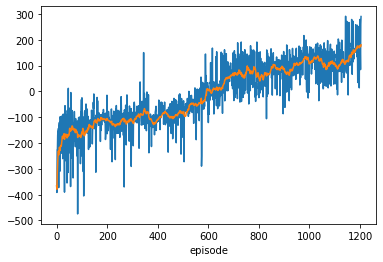

In [10]:
plt.plot(all_rewards)
plt.plot(avg_rewards)
plt.xlabel('episode')
plt.show()

# test

In [11]:
for i_episode in range(10):
  state = env.reset()
  R = 0
  for t in range(1000):
    state = nd.array(np.expand_dims(state, 0))
    action = ppo.policy_old.choose_action(state, memory)
    state, reward, done, _ = env.step(action)
    R += reward
    if done:
      break            
  print(i_episode,R)

0 238.35654848244386
1 237.83271118369947
2 238.39163854443348
3 265.74826492192176
4 305.79812009942265
5 66.93421217443262
6 223.20954969688802
7 264.4166658820544
8 286.6863565646854
9 21.416109780089286
